In [147]:
# importing moudles
# and using some magic to autoreload them if changed
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('./nonlin')
sys.path.append('./partion')
sys.path.append('./Probs')

from aspen import aspen
from newton import newton

import partion as pt
import wrapper as wp

from hb import transfer
from fix_bd_1D import fxbd_1D
import numpy as np
import matplotlib.pyplot as plt

test = wp.test_decorator(wp.test)
plt.style.use('default')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
# model to be studied
def model(u):
    return np.array([np.tanh(u)+1, 1/np.cosh(u)**2])

#x_t = np.linspace(0, 1)
#plt.plot(x_t, np.tanh(x_t))

In [149]:
class Coef():
    def __init__(self, Nx, Amp=0, Period=0, Scale=1, model=None):
        self.val = np.zeros((Nx, 1))
        for i in range(Nx):
            self.val[i] = (
                Amp * np.sin(Period * 2*np.pi * (i+1) / (Nx+1)) + 1) * Scale
        self.model = model

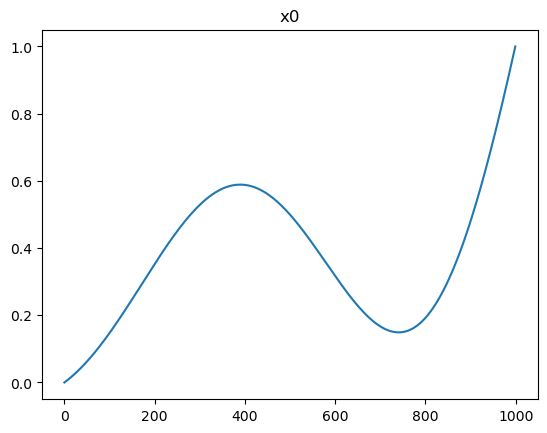

In [150]:
Nx = 1000
Nt = 10
param ={'Nx': Nx, 'Nt' : Nt}
x = np.linspace(0, 1, Nx)
C = Coef(Nx, 0.5, 1, 1.2e-1, model=model)
x0 = (1+0.8*np.sin(4*x*np.pi/2))*x
x0 = x0.reshape(-1, 1)
bd1 = x0[0]
bd2 = x0[-1]
plt.title('x0')
plt.plot(x0)
plt.show()

In [151]:
prob = transfer(C, param)
solver_n = fxbd_1D(param, prob)
solver_n.setBoundary(bd1, bd2)
#solver_n.setSources([0.7], [-0.2])
nl_solver = newton(crit_abs = 1e-10)
solver_n.setSolver(nl_solver)

In [152]:
solver_n.setInitial(x0)
X, mes, t_new, delta_new = test(solver_n, sample_size = 4)

test started
verdict : OK
time : 2.706 +- 0.3467
mean newton iterations:  4.0


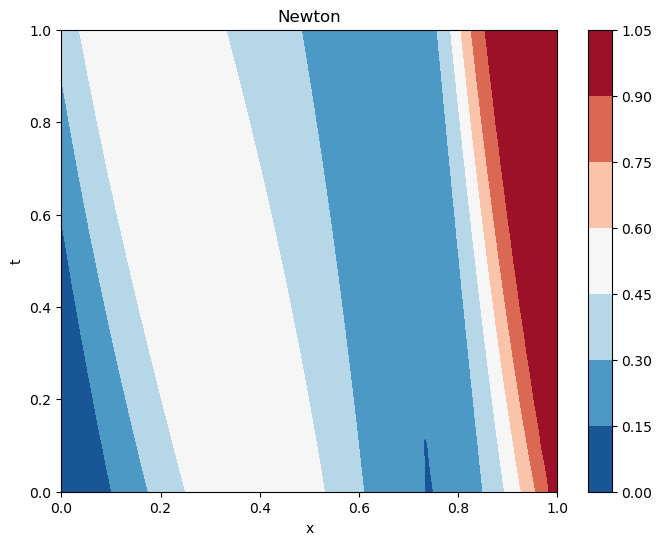

In [153]:
wp.show_res(solver_n)

In [154]:
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)
Nd = 4
partion = pt.partion_equally(Nx, Nd)
nl_solver = aspen(Nd, partion, crit_abs=1e-10)
solver.setSolver(nl_solver)

In [155]:
X, mes, t_eq, delta_eq = test(solver, sample_size=4)

test started
verdict : OK
time : 10.88 +- 0.8443
mean aspen iterations:  5.0


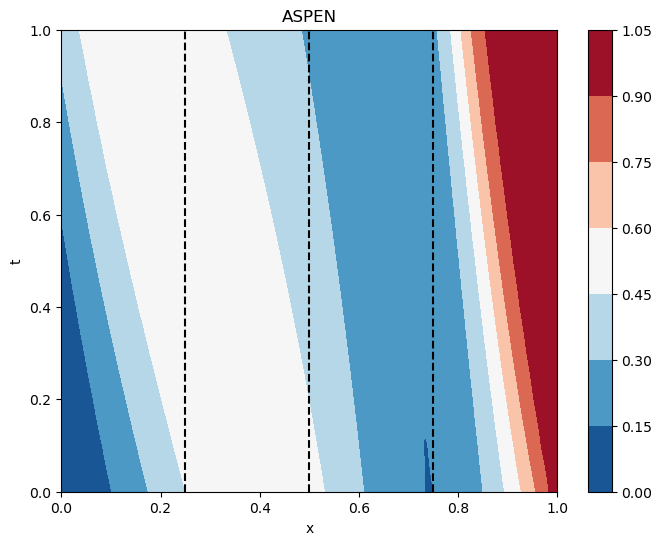

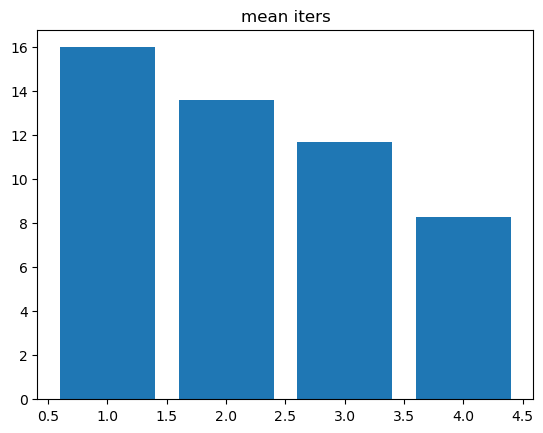

In [156]:
wp.show_res(solver, save='hyper1')
wp.bar_loc(solver, Nd, save='hyper2')

--time comparision--
newton : 2.819490909576416
aspen : 11.327965259552002


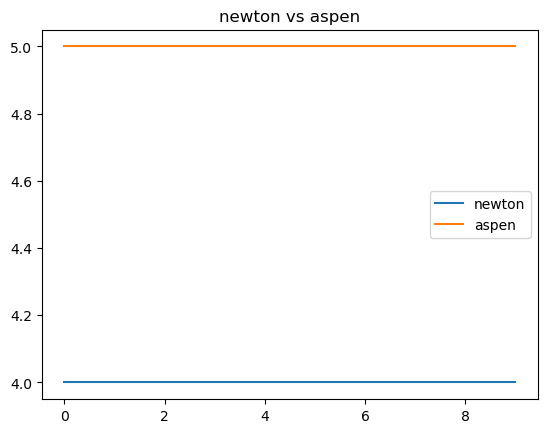

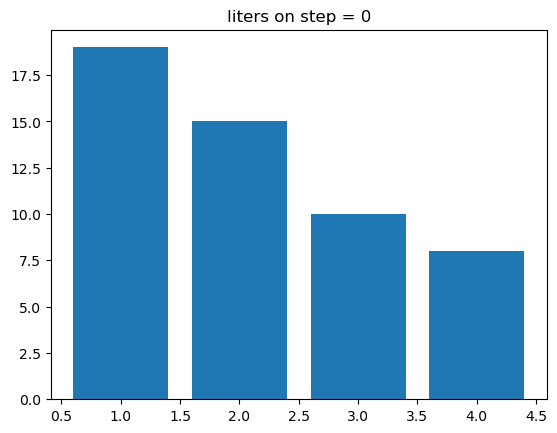

In [157]:
wp.compare([solver_n, solver], ['newton', 'aspen'], save='hyper, comp')
wp.bar_loc_step(solver, Nd, 0)

In [159]:
time = np.zeros((10, 2))
delta = np.zeros((10, 2))

Nx = 1000
Nd = 4

param ={'Nx': Nx, 'Nt' : Nt}
C = Coef(Nx, 0.5, 1, 1.2e-1, model=model)

nl_new = newton(crit_abs = 1e-6)
partion = pt.partion_equally(Nx, Nd)
nl_asp = aspen(Nd, partion, crit_abs=1e-6) 

for i in range(10):
    Nt = 5*(1+i)
    param ={'Nx': Nx, 'Nt' : Nt}
    prob = transfer(C, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setInitial(x0)
    
    solver.setSolver(nl_new)
    _, mes, time[i, 0], delta[i, 0] = test(solver, sample_size=4)
    if(mes != 'OK'):
        print(mes, i) 
        
    prob = transfer(C, param)
    solver = fxbd_1D(param, prob)
    solver.setBoundary(bd1, bd2)
    solver.setInitial(x0)
    solver.setSolver(nl_asp)
    _, mes, time[i, 1], delta[i, 1] = test(solver, sample_size=4)
    if(mes != 'OK'):
        print(mes, i) 


test started
verdict : OK
time : 1.132 +- 0.2834
mean newton iterations:  3.0
test started
verdict : OK
time : 4.402 +- 0.5621
mean aspen iterations:  5.0
test started
verdict : OK
time : 1.634 +- 0.3725
mean newton iterations:  2.0
test started
verdict : OK
time : 7.751 +- 0.2906
mean aspen iterations:  5.0
test started
verdict : OK
time : 2.459 +- 0.2721
mean newton iterations:  2.0
test started
verdict : OK
time : 9.087 +- 0.1129
mean aspen iterations:  3.0
test started
verdict : OK
time : 3.401 +- 0.4064
mean newton iterations:  2.0
test started
verdict : OK
time : 12.04 +- 0.4802
mean aspen iterations:  3.0
test started
verdict : OK
time : 4.05 +- 0.2997
mean newton iterations:  2.0
test started
verdict : OK
time : 15.72 +- 0.9011
mean aspen iterations:  3.0
test started
verdict : OK
time : 5.004 +- 0.4137
mean newton iterations:  2.0
test started
verdict : OK
time : 20.25 +- 0.946
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.463 +- 0.7082
mean newton iterations:

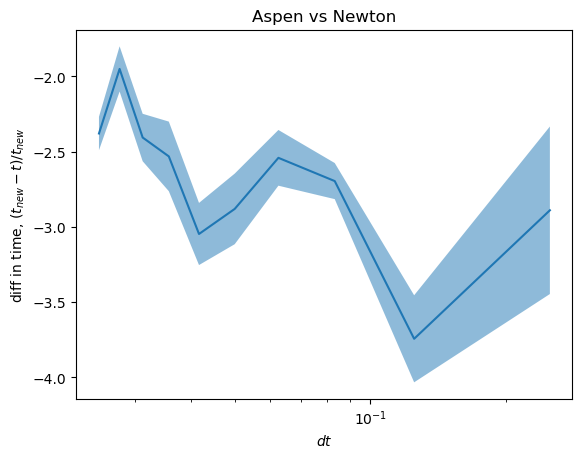

In [160]:
dif = 1 - time[:, 1]/time[:, 0]
dt = 1/(4*np.arange(1, 11))

plt.title('Aspen vs Newton')
plt.xlabel('$dt$')
plt.xscale('log')
plt.ylabel('diff in time, $(t_{new}-t) /t_{new}$')
plt.plot(dt, dif)
plt.fill_between(dt, dif+np.sqrt(delta[:, 0]**2+delta[:, 1]**2)/time[:, 0],
                dif-np.sqrt(delta[:, 0]**2+delta[:, 1]**2)/time[:, 0], alpha=0.5)
plt.savefig('./data/Hype0_dt_dep', dpi = 300)
plt.show()

In [161]:
Nx = 1000
Nt = 10
partion = pt.partion_equally(Nx, Nd)

param ={'Nx': Nx, 'Nt' : Nt}
prob = transfer(C, param)
solver = fxbd_1D(param, prob)
solver.setBoundary(bd1, bd2)
solver.setInitial(x0)

time = np.zeros(15)
delta = np.zeros(15)
gb_iters = np.zeros((15, Nt))
lc_iters = np.zeros((15, Nd, Nt))

i = 0
for crit_rel in np.logspace(-15, -0.05, 15):
    nl_solver = aspen(Nd, partion, newton_crit_rel = crit_rel)
    solver.setSolver(nl_solver)
    _, mes, time[i], delta[i] = test(solver, sample_size=4)
    gb_iters[i, :] = solver.timelog.aspen_iters
    lc_iters[i, :, :] = solver.timelog.domain_iters
    if(mes != 'OK'):
        print(i, mes)
    i += 1

test started
verdict : OK
time : 6.289 +- 0.83
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.218 +- 0.4254
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.261 +- 0.6281
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.67 +- 0.8073
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.57 +- 0.7436
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.604 +- 0.4467
mean aspen iterations:  3.0
test started
verdict : OK
time : 5.92 +- 0.2479
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.283 +- 0.6401
mean aspen iterations:  3.0
test started
verdict : OK
time : 7.73 +- 0.3881
mean aspen iterations:  3.0
test started
verdict : OK
time : 5.885 +- 0.2731
mean aspen iterations:  3.0
test started
verdict : OK
time : 5.841 +- 0.2927
mean aspen iterations:  3.0
test started
verdict : OK
time : 6.038 +- 0.3449
mean aspen iterations:  3.3
test started
verdict : OK
time : 5.85 +- 0.2466
mean aspen iterations:  4.0
test s

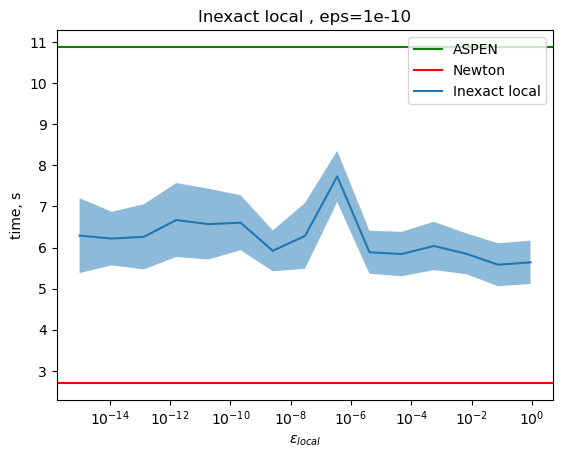

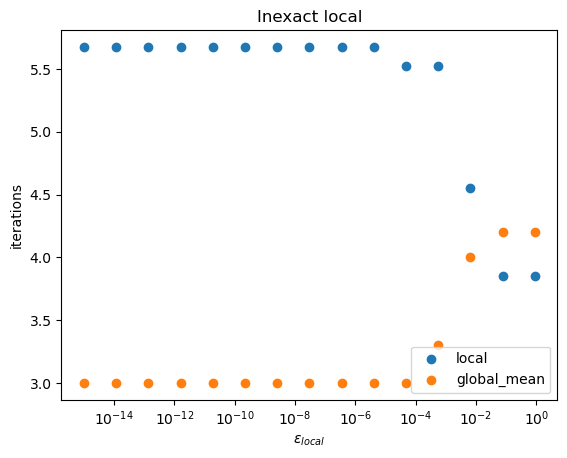

In [164]:
crit_rel = np.logspace(-15, -0.05, 15)

plt.title('Inexact local , eps=1e-10')
plt.ylabel('time, s')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.axhline(10.88, color='g', label='ASPEN')
plt.axhline(2.706, color='r', label='Newton')
plt.plot(crit_rel, time, label='Inexact local')
plt.fill_between(crit_rel, time+np.sqrt(delta),
                time-np.sqrt(delta), alpha=0.5)
plt.savefig('./data/Hype0_I_time', dpi=400)
plt.legend()
plt.show()

plt.title('Inexact local')
plt.ylabel('iterations')
plt.xlabel(r'$\varepsilon_{local}$')
plt.xscale('log')
plt.scatter(crit_rel, np.mean(np.mean(lc_iters, axis = 2), axis = 1), label='local')
plt.scatter(crit_rel, np.mean(gb_iters, axis = 1), label='global_mean')
plt.legend()
plt.savefig('./data/Hype0_I_lc_iters', dpi=400)
plt.show()

In [ ]:
wp.show_res(solver)
wp.bar_loc_step(solver, Nd, 0)